# CSE144 Final Project
Group Members: Russell Elliott, Neil Grover

In [151]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.models as models

In [152]:
# #Training Data
# X = torch.load('train_data.pth')
# y = torch.load('train_labels.pth') 

# X = X.permute(0, 3, 1, 2)

# print(X.shape)
# print(y.shape)

# #Make a model for training on the train data via a validation set. From there, we'll test our model via the test set
# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [153]:
# # Fix seed
# def set_seed(seed):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)

# set_seed(42)

In [154]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split

# Define the directory containing your images
data_dir = './train/'

# Define the transformations to be applied to each image
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize the image to 224x224
    transforms.ToTensor(),           # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

# Create a dataset from the folder structure
dataset = ImageFolder(root=data_dir, transform=transform)

print(len(dataset))

# Split the dataset into training and testing sets
train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)

# Create data loaders for the training and testing sets
train_loader = DataLoader(dataset, batch_size=8, sampler=torch.utils.data.SubsetRandomSampler(train_indices))
test_loader = DataLoader(dataset, batch_size=8, sampler=torch.utils.data.SubsetRandomSampler(test_indices))

print(len(train_loader))
print(len(test_loader))

1000
100
25


In [155]:
# # class VGG16Head(nn.Module):
# #     def __init__(self, num_classes=100):
# #         super(VGG16Head, self).__init__()
    
# #         self.fine = nn.Sequential(
# #             nn.Linear(1000, 100),
# #         )

# #     def forward(self, x):

# #         x = self.fine(x)

# #         return x

# model = models.resnet50(pretrained=True)
# # Freeze the feature layers
# for param in model.parameters():
#     param.requires_grad = False
# model.fc = nn.Linear(in_features=2048, out_features=100) #change parameters; might have to change this line
# print(model)
# # net = VGG16Head()
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #add weight decay parameter to prevent overfit?
# criterion = nn.CrossEntropyLoss()

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define your custom head
class CustomResNetHead(nn.Module):
    def __init__(self, in_features, num_classes=100):
        super(CustomResNetHead, self).__init__()
        self.fc = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Dropout(0.4),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

# Load the pretrained ResNet-50 model
model = models.resnet18(pretrained=True)
# Freeze the feature layers
for param in model.parameters():
    param.requires_grad = False

# Modify the fully connected layer
in_features = model.fc.in_features
model.fc = nn.Sequential (
    CustomResNetHead(in_features, 100)
)

# Print the modified model
print(model)
print(model.fc)

# Set up optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [156]:
# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            # images = images.permute(0, 3, 1, 2)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Training the network
num_epochs = 50
train_losses, test_losses = [], []
train_acc, test_acc = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        #inputs = inputs.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = calculate_accuracy(train_loader, model)
    train_acc.append(train_accuracy)

    test_loss = 0.0
    for data in test_loader:
        images, labels = data
        #images = images.permute(0, 3, 1, 2)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = calculate_accuracy(test_loader, model)
    test_acc.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

Epoch 1/50, Train Loss: 3.8493, Train Acc: 86.12%, Test Loss: 2.5070, Test Acc: 79.50%
Epoch 2/50, Train Loss: 0.8587, Train Acc: 99.50%, Test Loss: 0.1596, Test Acc: 99.50%
Epoch 3/50, Train Loss: 0.0940, Train Acc: 99.62%, Test Loss: 0.0555, Test Acc: 100.00%
Epoch 4/50, Train Loss: 0.0440, Train Acc: 99.88%, Test Loss: 0.0258, Test Acc: 100.00%
Epoch 5/50, Train Loss: 0.0129, Train Acc: 99.88%, Test Loss: 0.0120, Test Acc: 100.00%
Epoch 6/50, Train Loss: 0.0131, Train Acc: 99.88%, Test Loss: 0.0138, Test Acc: 100.00%
Epoch 7/50, Train Loss: 0.0068, Train Acc: 99.88%, Test Loss: 0.0060, Test Acc: 100.00%
Epoch 8/50, Train Loss: 0.0062, Train Acc: 99.88%, Test Loss: 0.0121, Test Acc: 100.00%


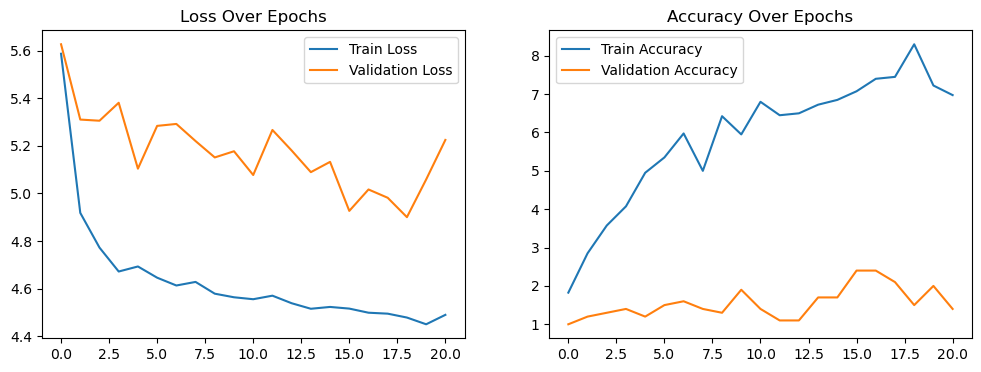

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()